# Bootstrap IRR Estimation for Determining an Overlap Stopping Criteria
This notebook is for evaluating an experiment of estimating IRR via bootstrap sampling. [Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#approach) has a good summary of the bootstrap methodology in the approach section. 

The idea is that we want to _estimate_ what the true/population value of some IRR metric is. This is the value we would get if we had 100% annotation overlap over all of the data and could calculate it. With a bootstrap sample, we can get a confidence interval around this value at any number of overlapped annotated examples. And the interval _is_ actually what we care about, not the true value (since it's unknown when we start the task what the IRR will be). So, you could have users annotate examples with overlap until some criteria about the range of the confidence interval for the IRR value is reached. For example, with Cohen's kappa you have the standard interpretation of the "level of agreement" qualitatively increasing every 0.2. So you might want to annotate with overlap until your 95% confidence interval is 0.2. Going back to the original idea - this means that if we use the 95% confidence interval, there's a 95% chance the true/population `kappa` is within that interval that we get.

The primary advantage of this, over something like _power analysis_, is that you can calcualte the bootstrap for any metric or statistic that you care about. That means the input to the algorithm that would use this is basically two things: what to do with the stream of existing overlapped annotations (i.e. get spans if it's NER, labels if its textcat, etc) and how the metric of iterest is calcualted on those annotations. This means it can be expanded to metrics that account for different tasks **and** different numbers of annotators, and users could pass custom IRR (or maybe some other "overlap" stoppage) functions.

## This Notebook

This notebook runs a simulation of what this might look like for a binary text classification task with two annotators. To do this, we generate some synthetic binary data that's correlated at some specified value, then use that synthetic data to simulate an annotation scenario. In this scenario, two annotators start with full overlap - they both annotate all examples. When we reach some stopping criteria, defined by the width of the 95% confidence interval, we could switch to no overlap (or some other overlap paradigm).


In [1]:
import random
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import iqr
import pandas as pd
from sklearn.metrics import cohen_kappa_score

plt.rcParams.update({"figure.dpi": 144})

In [2]:
# https://stats.stackexchange.com/a/483070
# For generating correlated binary data


def bernoulli_sample(n=100, p=0.5, q=0.5, rho=0.0):
    p1 = rho * np.sqrt(p * q * (1 - p) * (1 - q)) + (1 - p) * (1 - q)
    p2 = 1 - p - p1
    p3 = 1 - q - p1
    p4 = p1 + p + q - 1
    samples = np.random.choice([0, 1, 2, 3], size=n, replace=True, p=[p1, p2, p3, p4])
    samples = list(
        map(lambda x: np.array(tuple(np.binary_repr(x, width=2))).astype(int), samples)
    )
    return np.array(samples).sum(0)


def gen_correlated_bernoulli(size, n=100, p=0.1, q=0.1, rho=0.0):
    return np.array([bernoulli_sample(n, p, q, rho) for _ in range(size)])

### Synthetic Data Generation Parameters

- `LENGTH`: Total number of examples we could possibly annotate, this is the "population" of data
- `OUTCOME_RATE`: We're going to generate some fictional data for a binary classification task. We'll use the number below to determine the outcome rate for a task, which will be used to generate data for our fictional annotators. This is the percent of positive labels.
- `CORRELATION`: We'll generate correlated binary data for this simulation. Imagine this parameter as generating data with a latent 'agreement' between the two annotators. `CORRELATION ∝ agreement`
  - In the binary case, the actual emperical `CORRELATION` value will sometimes be equal to kappa.

In [3]:
LENGTH = 1000
OUTCOME_RATE = 0.3
CORRELATION = 0.7

Next we generate the data and summarize it with the "true" population kappa value. This is the value we would get if we had done 100% overlap over all the examples.

In [4]:
sample_annotations = gen_correlated_bernoulli(
    LENGTH, n=1, p=OUTCOME_RATE, q=OUTCOME_RATE, rho=CORRELATION
)
a1, a2 = zip(*sample_annotations)
true_k = cohen_kappa_score(a1, a2)

print("A1 Positive:", sum(a1), ", percent:", sum(a1) / LENGTH)
print("A2 Positive:", sum(a2), ", percent:", sum(a2) / LENGTH)
print("Population (True) Kappa:", true_k)
print("Actual (Empirical) Correlation:", np.min(np.corrcoef(a1, a2)))
print("Input Correlation:", CORRELATION)

A1 Positive: 294 , percent: 0.294
A2 Positive: 287 , percent: 0.287
Population (True) Kappa: 0.7549994663354712
Actual (Empirical) Correlation: 0.7551083337650581
Input Correlation: 0.7


###  Experimental parameters

We're going to run an experiment to try and figure out what a reasonable cutoff is for the number of examples where we should have overlap. We have two parameters to control here:

- `EVAL_EVERY`: We're going to calculate a boostrap of the IRR every `EVAL_EVERY` examples. The idea here in an applied scenario is that we would start out with users annotating with 100% overlap in examples, and once we're confident in an estimate of the IRR (via distribution of the bootstrap samples), we would "eject" from the overlap paradigm and go back to single annotation.
- `N_ITERATIONS`: Number of times to perform the bootstrap sampling procedure. 

In [5]:
# We'll pretend we're annotating iteratively and calculating the bootstrap sample on EVAL_EVERY
EVAL_EVERY = 25
N_ITERATIONS = 250
# Wikipedia had a reference to a nice article about how 100 samples can be "good enough" in practice.
# at least for partial-least squares models.
# https://misq.umn.edu/skin/frontend/default/misq/pdf/appendices/2012/V36I3_Appendices/GoodhueResearchNoteAppendix.pdf
# I think computation is cheap so I go with something a little higher, but this can also be a parameter
# a user chooses


samples = {}
for eval_iter in range(EVAL_EVERY, len(a1), EVAL_EVERY):
    sample_k = []
    for i in range(N_ITERATIONS):
        pairs = list(zip(a1[:eval_iter], a2[:eval_iter]))
        pairs = random.choices(pairs, k=len(pairs))
        a1_sample, a2_sample = zip(*pairs)
        k = cohen_kappa_score(a1_sample, a2_sample)
        # We might get some NaNs here or warnings from numpy if our outcome is rare and we have samples
        # of all the same label
        sample_k.append(k)
    samples[eval_iter] = sample_k

In [6]:
df = pd.DataFrame(samples).unstack().dropna().reset_index()
df.columns = ["eval_iter", "sample_id", "k"]

In [7]:
CONFIDENCE_INTERVAL = 0.95
# We want to stop annotating with overlap when the CI is < this value
WIDTH_THRESHOLD = 0.2

ci_lower, ci_upper = ((1 - CONFIDENCE_INTERVAL) / 2), 1 - (
    (1 - CONFIDENCE_INTERVAL) / 2
)

bootstrap_stats_df = df.groupby("eval_iter").agg(
    mean=("k", "mean"),
    std=("k", "std"),
    ci_lower=("k", partial(np.quantile, q=ci_lower)),
    ci_upper=("k", partial(np.quantile, q=ci_upper)),
).assign(
    ci_width=lambda d: d["ci_upper"] - d["ci_lower"],
    lt_width=lambda d: d["ci_width"] < WIDTH_THRESHOLD,
    true_kappa=true_k,
)
bootstrap_stats_df

,mean,std,ci_lower,ci_upper,ci_width,lt_width,true_kappa
eval_iter,,,,,,,
25,0.826820,0.118155,0.573379,1.000000,0.426621,False,0.754999
50,0.806871,0.092830,0.592254,0.956063,0.363810,False,0.754999
75,0.617849,0.108046,0.396894,0.828424,0.431530,False,0.754999
100,0.728338,0.079553,0.573597,0.868369,0.294772,False,0.754999
125,0.744516,0.073908,0.598630,0.876523,0.277893,False,0.754999
150,0.764278,0.061375,0.644294,0.879768,0.235474,False,0.754999
175,0.785077,0.045946,0.691848,0.868257,0.176410,True,0.754999
200,0.776629,0.048798,0.688208,0.864367,0.176159,True,0.754999
225,0.785529,0.047413,0.693619,0.881476,0.187857,True,0.754999


Below we'll print the first iteration in which our CI width is less than our desired interval. In practice, we may want to use something like a patience value in early stopping: the first instance in which we meet this criteria might just be a fluke, we may want to wait until `p` iterations in a row meet the criteria (or change some other sampling parameters to give us more confidence).

In [8]:
print("First evaluation with CI less than desired width")
bootstrap_stats_df.query("lt_width").head(1)

First evaluation with CI less than desired width


,mean,std,ci_lower,ci_upper,ci_width,lt_width,true_kappa
eval_iter,,,,,,,
175,0.785077,0.045946,0.691848,0.868257,0.17641,True,0.754999


## Plots
These are meant to view the distrubtion of IRR samples at each evaluation iteration. 

Beware of the histogram, because of the binning algorithm it may not look like the true value is captured in the most common bin. It's better to reference the table above if you're looking for more precision around the interval.

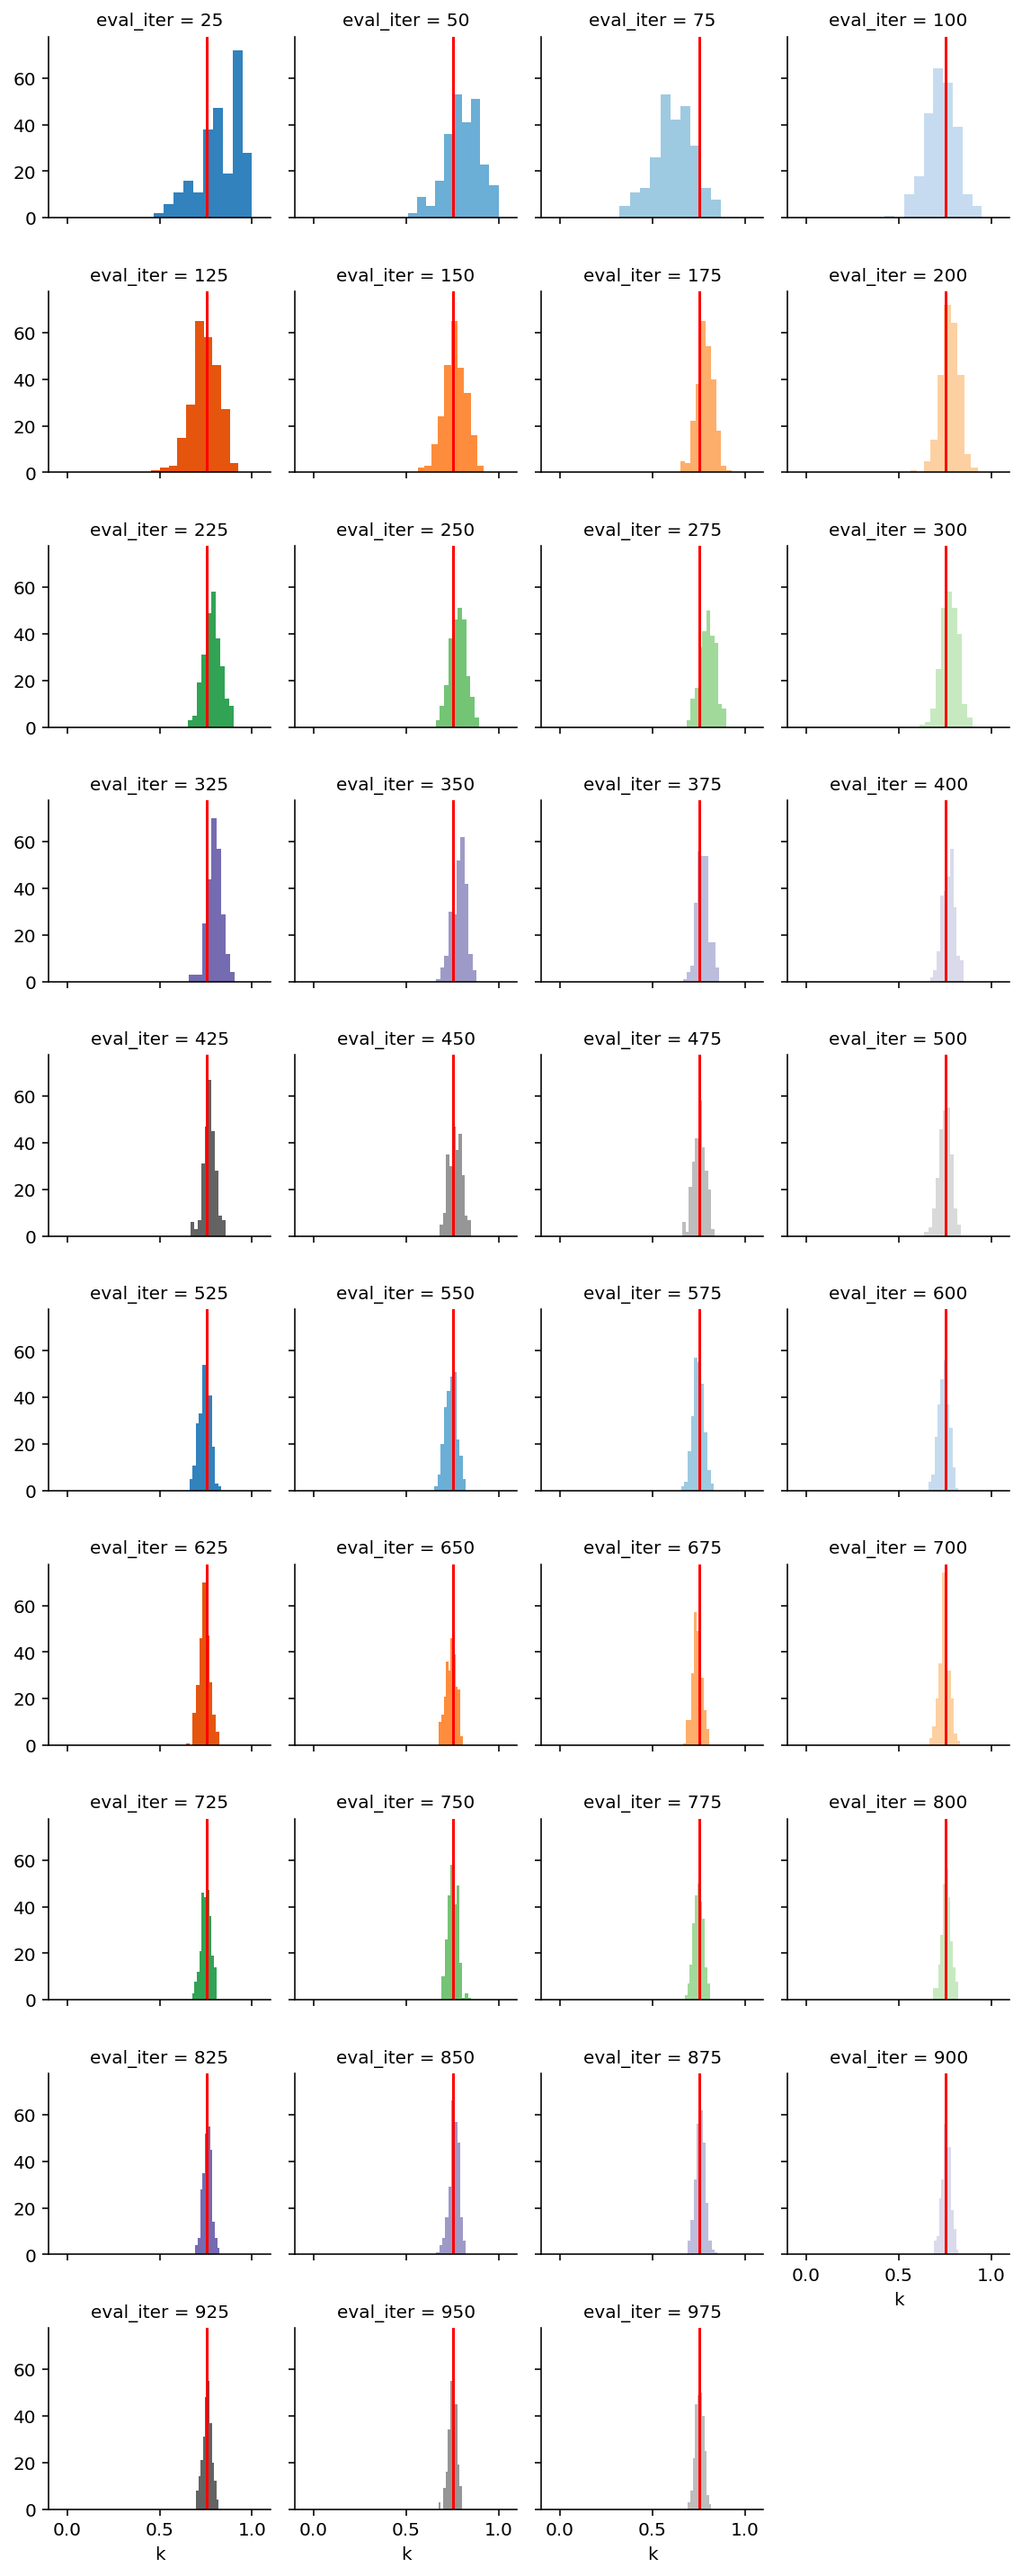

In [9]:
grid = sns.FacetGrid(
    df, col="eval_iter", hue="eval_iter", palette="tab20c", col_wrap=4, height=2
)

# Draw a horizontal line to show the starting point
grid.refline(x=true_k, linestyle="-", c="red")

grid.map(plt.hist, "k", bins=10)

# Adjust the tick positions and labels
grid.set(xticks=[0, 0.5, 1], xlim=(-0.1, 1.1))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

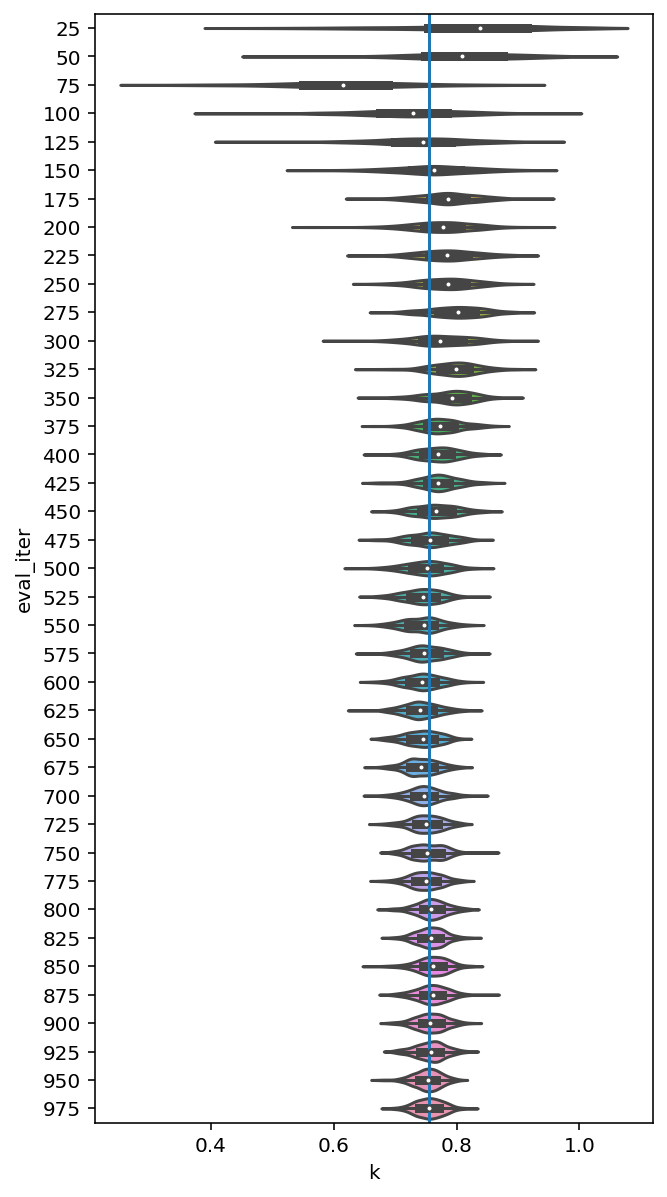

In [10]:
plot = sns.violinplot(
    data=df.assign(eval_iter=lambda x: x["eval_iter"].astype(str)),
    x="k",
    y="eval_iter",
    height=500,
    aspect=0.5,
)
plot.figure.set_size_inches(w=5, h=10)
plot.axvline(true_k)